In [1]:
pip install statsforecast

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 354.4/354.4 kB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 285.8/285.8 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.2/278.2 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.3/135.3 kB 4.3 MB/s eta 0:00:00


In [2]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA
from statsforecast.arima import arima_string
from scipy.stats import norm
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from datetime import datetime
import seaborn as sns

warnings.filterwarnings('ignore')

# 1

## c)

In [3]:
def ts_display(series, lags=24):
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(9, 5))
    sns.lineplot(series, ax=ax1)
    ax1.set_title('Временной ряд')
    plot_acf(series, lags=lags, ax=ax2)
    plot_pacf(series, lags=lags, ax=ax3)

    ax1.set_xlabel('Время')
    ax3.set_xlabel('Номер лага')

    ax1.set_ylabel('Значение')
    ax2.set_ylabel('Значение')
    ax3.set_ylabel('Значение')

    plt.tight_layout()
    plt.show()

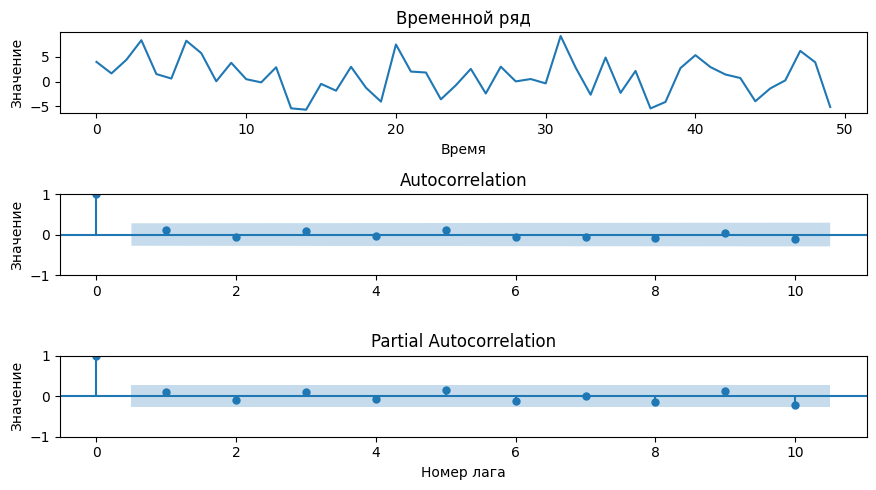

In [4]:
np.random.seed(42)
n_obs = 50

ma2 = 2 + ArmaProcess(ar=[1], ma=[1, 0.1, -0.06]).generate_sample(nsample=n_obs, scale=4)

ts_display(ma2, 10)

## d)

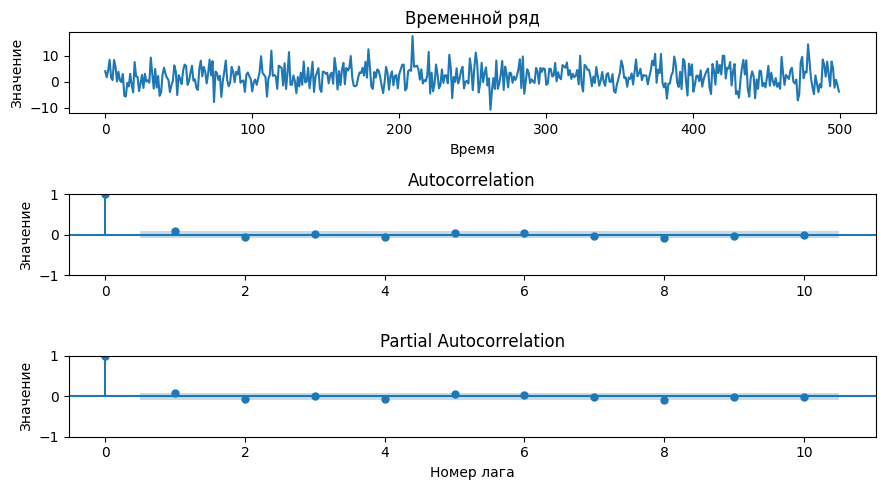

In [5]:
np.random.seed(42)
n_obs = 500

ma2 = 2 + ArmaProcess(ar=[1], ma=[1, 0.1, -0.06]).generate_sample(nsample=n_obs, scale=4)

ts_display(ma2, 10)

# 2

## c)

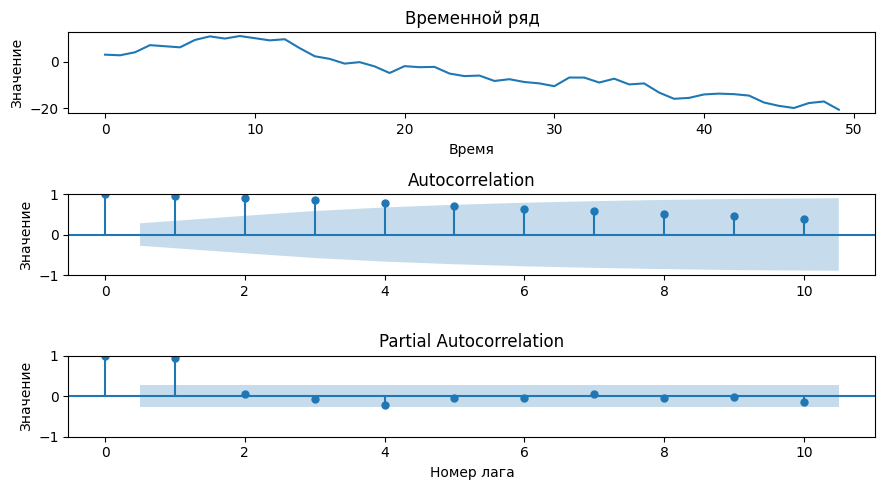

In [6]:
np.random.seed(42)
n_obs = 50

ar1 = 2 + ArmaProcess(ar=[1, -1], ma=[1]).generate_sample(nsample=n_obs, scale=2)

ts_display(ar1, 10)

## d)

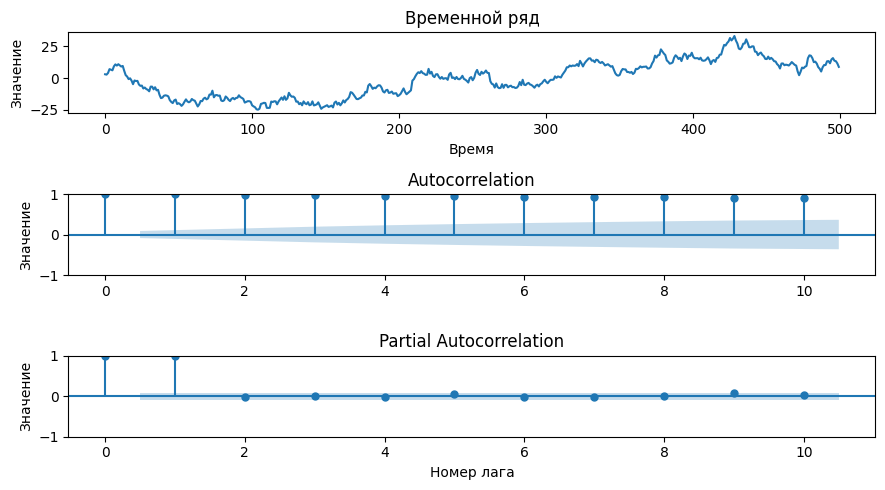

In [7]:
np.random.seed(42)
n_obs = 500

ar1 = 2 + ArmaProcess(ar=[1, -1], ma=[1]).generate_sample(nsample=n_obs, scale=2)

ts_display(ar1, 10)

# 3

https://rosstat.gov.ru/storage/mediabank/tab1-zpl_03-2025.xlsx

## a)

In [8]:
ts = pd.read_excel('wage_data.xlsx')
ts.date = pd.to_datetime(ts.date, format='%Y')
ts = ts.set_index('date')
ts.head()

,wage
date,
1991-01-01,0.548
1992-01-01,6.000
1993-01-01,58.700
1994-01-01,220.400
1995-01-01,472.400


In [9]:
tr = pd.date_range(start='1/1/1991', end='1/1/2024', freq='YS')
df = pd.DataFrame({'wage': ts.wage}, index=tr)
df.index.name = 'date'
df.head()

,wage
date,
1991-01-01,0.548
1992-01-01,6.000
1993-01-01,58.700
1994-01-01,220.400
1995-01-01,472.400


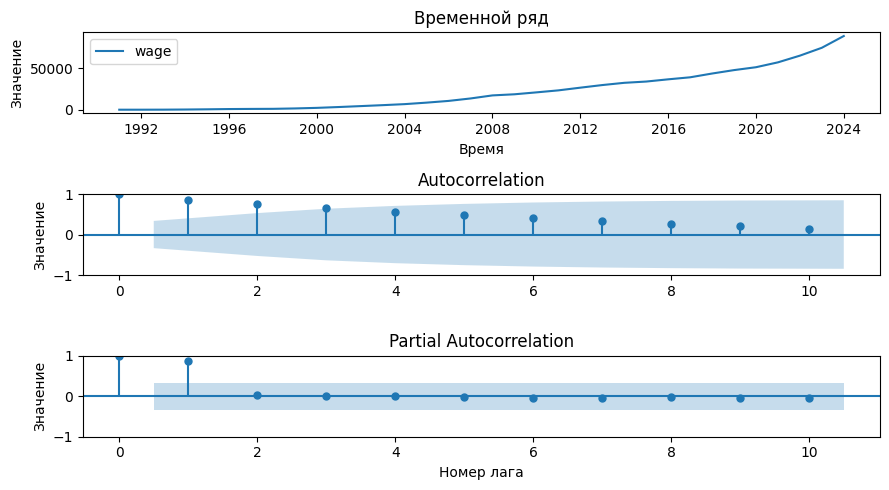

In [10]:
ts_display(df, 10)

## b)

In [11]:
result = adfuller(df, regression='ct', autolag='AIC')
print('ADF Statistic: %.3f' % result[0])
print('p-value: %.3f' % result[1])

ADF Statistic: 3.242
p-value: 1.000


## c)

In [12]:
df = pd.Series(df['wage'], index=df.index)

In [13]:
np.random.seed(42)

# 2. ETS(A,A,N) - Holt-Winters с аддитивными компонентами
ets_aan = ETSModel(df,
                    trend='add',
                    seasonal=None,
                    freq='YS').fit()

print(ets_aan.summary())

                                 ETS Results                                  
Dep. Variable:                   wage   No. Observations:                   34
Model:                       ETS(AAN)   Log Likelihood                -290.354
Date:                Thu, 12 Jun 2025   AIC                            590.709
Time:                        10:35:38   BIC                            598.340
Sample:                    01-01-1991   HQIC                           593.311
                         - 01-01-2024   Scale                      1531542.013
Covariance Type:               approx                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
smoothing_level     0.9999      0.310      3.221      0.001       0.391       1.608
smoothing_trend     0.9998      0.268      3.730      0.000       0.474       1.525
initial_level    -206.5654   124

## d)

In [14]:
alpha = ets_aan.smoothing_level
beta  = ets_aan.smoothing_trend

l_T = ets_aan.level.iloc[-1]
b_T = ets_aan.slope.iloc[-1]

sigma = np.sqrt(ets_aan.scale)

conf = 0.80
z = norm.ppf(0.5 + conf / 2)

In [15]:
print(f'80%-интервал для одного шага: [{round(l_T + b_T - z *  sigma, 2)} ; {round(l_T + b_T + z *  sigma, 2)}]')
print(f'80%-интервал для двух шагов: [{round(l_T + 2 * b_T - z *  sigma * np.sqrt((alpha + beta) ** 2 + 1), 2)} ; {round(l_T + 2 * b_T + z *  sigma * np.sqrt((alpha + beta) ** 2 + 1), 2)}]')

80%-интервал для одного шага: [101696.74 ; 104868.72]
80%-интервал для двух шагов: [113950.98 ; 121042.89]


## e)

In [16]:
fc_res = ets_aan.get_prediction(start=df.index[-1] + pd.DateOffset(years=1), end = df.index[-1] + pd.DateOffset(years=2))
fc_res.summary_frame(alpha=0.2).drop(columns='mean').round(2)

,pi_lower,pi_upper
2025-01-01,101696.74,104868.72
2026-01-01,113950.98,121042.89


## f)


In [17]:
np.random.seed(42)

p_list = np.arange(0, 2)
q_list = np.arange(0, 4)
d_list = np.arange(0, 3)

pdq = [(p, d, q) for p in p_list for q in q_list for d in d_list]

ic = {}

for (p, d, q) in pdq:
    arima = ARIMA(df, order=(p, d, q), freq = 'YS').fit()
    print(p, d, q)
    print(f'AIC: {arima.aic.round(3)}, BIC: {arima.bic.round(3)}')
    ic[(arima.aic, arima.bic)] = (p, d, q)

0 0 0
AIC: 872.836, BIC: 875.889
0 1 0
AIC: 643.544, BIC: 645.04
0 2 0
AIC: 550.45, BIC: 551.915
0 0 1
AIC: 750.11, BIC: 754.689
0 1 1
AIC: 619.22, BIC: 622.213
0 2 1
AIC: 551.498, BIC: 554.429
0 0 2
AIC: 727.002, BIC: 733.108
0 1 2
AIC: 600.104, BIC: 604.593
0 2 2
AIC: 550.095, BIC: 554.492
0 0 3
AIC: 692.369, BIC: 700.001
0 1 3
AIC: 593.223, BIC: 599.209
0 2 3
AIC: 551.357, BIC: 557.22
1 0 0
AIC: 671.89, BIC: 676.47
1 1 0
AIC: 569.069, BIC: 572.062
1 2 0
AIC: 550.847, BIC: 553.778
1 0 1
AIC: 648.203, BIC: 654.308
1 1 1
AIC: 570.112, BIC: 574.602
1 2 1
AIC: 548.178, BIC: 552.575
1 0 2
AIC: 629.973, BIC: 637.605
1 1 2
AIC: 568.92, BIC: 574.906
1 2 2
AIC: 551.835, BIC: 557.698
1 0 3
AIC: 623.049, BIC: 632.208
1 1 3
AIC: 570.164, BIC: 577.646
1 2 3
AIC: 547.961, BIC: 555.29


In [18]:
min_aic = min(ic.keys(), key=lambda x: x[0])
min_bic = min(ic.keys(), key=lambda x: x[1])

print(f'Минимальный AIC: {min_aic[0].round(3)}, Параметры: {ic[min_aic]}')
print(f'Минимальный BIC: {min_bic[1].round(3)}, Параметры: {ic[min_bic]}')

Минимальный AIC: 547.961, Параметры: (np.int64(1), np.int64(2), np.int64(3))
Минимальный BIC: 551.915, Параметры: (np.int64(0), np.int64(2), np.int64(0))


In [19]:
arima_best_aic = ARIMA(df, order=(1, 2, 3), freq = 'YS').fit()
arima_best_bic = ARIMA(df, order=(0, 2, 0), freq = 'YS').fit()

print(arima_best_aic.summary())
print(arima_best_bic.summary())

                               SARIMAX Results                                
Dep. Variable:                   wage   No. Observations:                   34
Model:                 ARIMA(1, 2, 3)   Log Likelihood                -268.980
Date:                Thu, 12 Jun 2025   AIC                            547.961
Time:                        10:35:52   BIC                            555.290
Sample:                    01-01-1991   HQIC                           550.390
                         - 01-01-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0000      0.214      4.680      0.000       0.581       1.419
ma.L1         -1.0592      0.455     -2.328      0.020      -1.951      -0.167
ma.L2          0.2253      0.481      0.469      0.6

In [20]:
arima_best = ARIMA(df, order=(1, 2, 3), freq = 'YS').fit()
print(f'AIC: {arima_best.aic.round(3)}, BIC: {arima_best.bic.round(3)}')

AIC: 547.961, BIC: 555.29


## g)

In [21]:
df_statsforecast = df.copy().reset_index().rename(columns={'date': 'ds', 'wage': 'y'})
df_statsforecast['unique_id'] = 0

model = [AutoARIMA(seasonal=False)]

arima_auto = StatsForecast(models = model, freq = 'YS').fit(df_statsforecast)

print(arima_string(arima_auto.fitted_[0,0].model_))
print(f"AIC: {arima_auto.fitted_[0,0].model_['aic'].round(3)}, BIC: {arima_auto.fitted_[0,0].model_['bic'].round(3)}")

arima_auto.forecast(h=2, df=df_statsforecast, fitted=True)

ARIMA(1,2,1)                   
AIC: 547.59, BIC: 551.987


,unique_id,ds,AutoARIMA
0,0,2025-01-01,105317.305892
1,0,2026-01-01,123354.766679


## h)

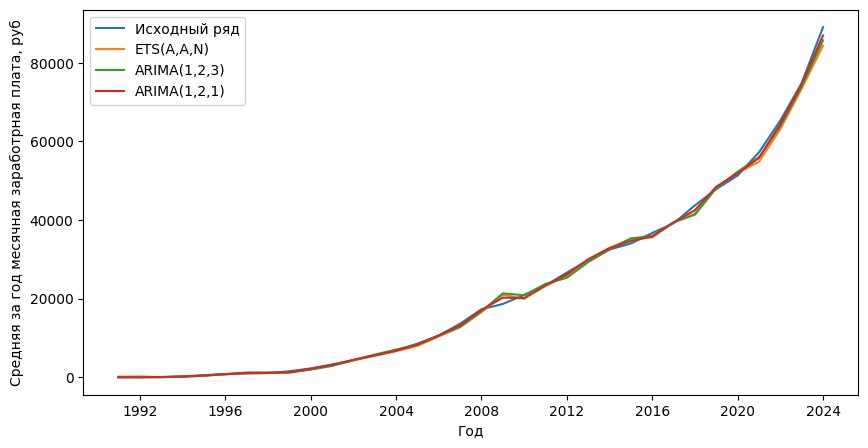

In [22]:
fig, ax = plt.subplots(figsize = (10, 5))

sns.lineplot(df, ax=ax, label='Исходный ряд')
sns.lineplot(ets_aan.fittedvalues, ax=ax, label='ETS(A,A,N)')
sns.lineplot(arima_best.fittedvalues, ax=ax, label='ARIMA(1,2,3)')
sns.lineplot(y=arima_auto.forecast_fitted_values().AutoARIMA, x=df_statsforecast.ds, ax=ax, label='ARIMA(1,2,1)')
plt.legend()

ax.set_xlabel('Год')
ax.set_ylabel('Средняя за год месячная заработрная плата, руб')

plt.show()

# 4
https://rp5.ru/Архив_погоды_в_Москве_(ВДНХ)

## a)

In [23]:
temp_data = pd.read_csv('/content/temperature_data.csv', encoding='utf-8', sep=';', index_col=0)
temp_data.head()

,Местное время в Москве (ВДНХ),T,Po,P,Pa,U,DD,Ff,ff10,ff3,...,Cm,Ch,VV,Td,RRR,tR,E,Tg,E',sss
10.06.2025 21:00,16.1,748.5,761.8,0.7,50.0,"Ветер, дующий с западо-северо-запада",1.0,NaN,NaN,"90 или более, но не 100%",...,"Перистые нитевидные, иногда когтевидные, не ра...",20.0,5.7,Осадков нет,12.0,NaN,NaN,NaN,NaN,NaN
10.06.2025 18:00,18.8,747.8,761.0,0.2,42.0,"Ветер, дующий с северо-запада",1.0,NaN,NaN,60%.,...,Перистые (часто в виде полос) и перисто-слоист...,20.0,5.6,Осадков нет,12.0,NaN,NaN,NaN,NaN,NaN
10.06.2025 15:00,19.9,747.6,760.6,-0.2,41.0,"Ветер, дующий с западо-северо-запада",1.0,NaN,NaN,20–30%.,...,"Перистых, перисто-кучевых или перисто-слоистых...",20.0,6.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10.06.2025 12:00,18.8,747.8,761.0,0.1,47.0,"Ветер, дующий с северо-запада",1.0,NaN,NaN,70 – 80%.,...,"Перистые нитевидные, иногда когтевидные, не ра...",20.0,7.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10.06.2025 09:00,16.3,747.7,761.0,0.6,62.0,"Ветер, дующий с западо-северо-запада",2.0,NaN,NaN,70 – 80%.,...,"Перистых, перисто-кучевых или перисто-слоистых...",20.0,9.0,Осадков нет,12.0,Поверхность почвы влажная.,14.0,NaN,NaN,NaN


In [24]:
df = pd.DataFrame(temp_data['Местное время в Москве (ВДНХ)'])
df.rename({'Местное время в Москве (ВДНХ)': 'temp'}, axis=1,inplace=True)
df.index.name = 'date'
df.index = pd.to_datetime(df.index, format='%d.%m.%Y %H:%M')
df.sort_index(inplace=True)
df.head()

,temp
date,
2010-06-10 00:00:00,12.8
2010-06-10 03:00:00,10.1
2010-06-10 06:00:00,10.7
2010-06-10 09:00:00,15.3
2010-06-10 12:00:00,17.6


In [25]:
df = df.groupby(pd.Grouper(freq='M')).mean()
df

,temp
date,
2010-06-30,19.333333
2010-07-31,25.998776
2010-08-31,21.794332
2010-09-30,11.710833
2010-10-31,3.830645
...,...
2025-02-28,-4.797321
2025-03-31,4.189516
2025-04-30,8.813333


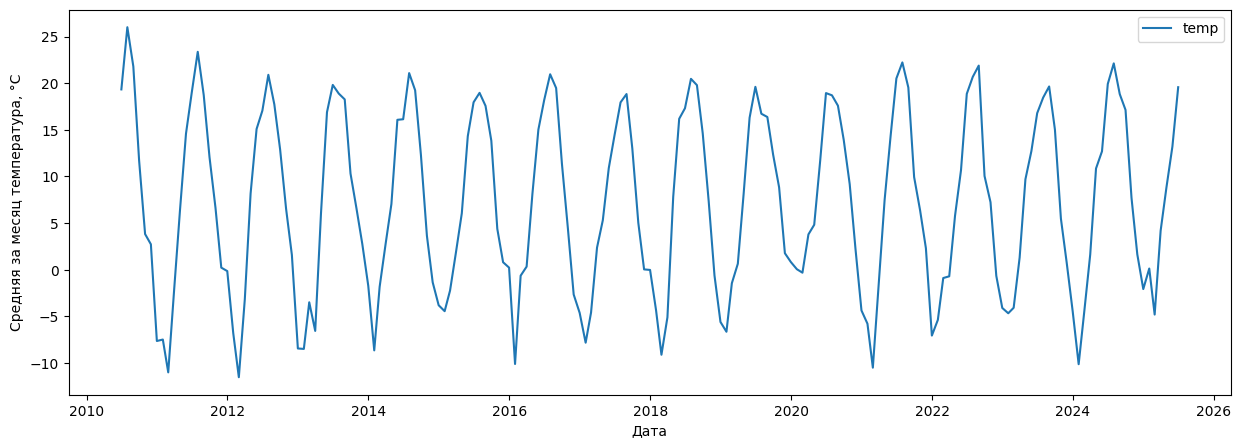

In [26]:
fig, ax= plt.subplots(figsize=(15, 5))
sns.lineplot(df, ax=ax)

ax.set_xlabel('Дата')
ax.set_ylabel('Средняя за месяц температура, °C')

plt.show()

In [27]:
df = pd.Series(df['temp'], index=df.index)

Поскольку температура в градусах Цельсия принимает в том числе отрицательные значения, а мне нужно будет оценить модель для логарифма ряда, то я переведу температуру в шкалу Кельвина, чтобы остались только положительные значения.

In [28]:
df_kelvin = df.copy()
df_kelvin = df_kelvin.apply(lambda x: x + 273.15)
df_kelvin

,temp
date,
2010-06-30,292.483333
2010-07-31,299.148776
2010-08-31,294.944332
2010-09-30,284.860833
2010-10-31,276.980645
...,...
2025-02-28,268.352679
2025-03-31,277.339516
2025-04-30,281.963333


In [29]:
ets_aaa = ETSModel(df_kelvin,
                    trend='add',
                    seasonal='add',
                    seasonal_periods=12,
                    freq='M',
                    initialization_method="estimated").fit()

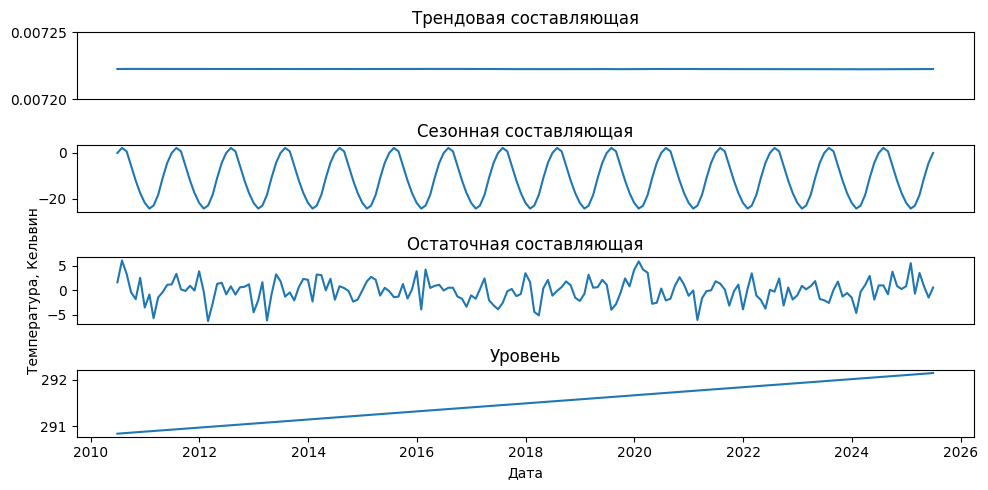

In [30]:
fig, ax = plt.subplots(figsize=(10, 5), nrows = 4, ncols=1)

sns.lineplot(ets_aaa.slope, ax=ax[0])
sns.lineplot(ets_aaa.season, ax=ax[1])
sns.lineplot(ets_aaa.resid, ax=ax[2])
sns.lineplot(ets_aaa.level, ax=ax[3])

ax[0].set_xlabel('Номер лага')

ax[3].set_xlabel('Дата')
ax[3].set_ylabel('')

ax[0].set_xlabel('')
ax[1].set_xlabel('')
ax[0].set_xticks([])
ax[1].set_xticks([])
ax[2].set_xlabel('')
ax[2].set_xticks([])

ax[2].set_ylabel('Температура, Кельвин')

ax[0].set_ylabel('')
ax[0].set_ylim(0.0072, 0.00725)


ax[0].set_title('Трендовая составляющая')
ax[1].set_title('Сезонная составляющая')
ax[2].set_title('Остаточная составляющая')
ax[3].set_title('Уровень')

ax[1].set_ylabel('')

plt.tight_layout()

plt.show()

## b)


In [31]:
test_size = 24
train, test = df_kelvin[:df_kelvin.shape[0] - test_size], df_kelvin[df_kelvin.shape[0] - test_size:]

## c)

In [32]:
ets_aaa_base = ETSModel(train,
                    trend='add',
                    seasonal='add',
                    seasonal_periods=12,
                    freq='M',
                    initialization_method="estimated").fit()
print(ets_aaa_base.summary())

                                 ETS Results                                  
Dep. Variable:                   temp   No. Observations:                  157
Model:                       ETS(AAA)   Log Likelihood                -354.426
Date:                Thu, 12 Jun 2025   AIC                            744.851
Time:                        10:36:04   BIC                            799.864
Sample:                    06-30-2010   HQIC                           767.194
                         - 06-30-2023   Scale                            5.350
Covariance Type:               approx                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
smoothing_level         0.0001        nan        nan        nan         nan         nan
smoothing_trend          1e-08      0.002   4.42e-06      1.000      -0.004       0.004
smoothing_season

In [33]:
last_season = train.iloc[-12:].values
snaive_forecast = pd.Series(
    np.tile(last_season, 2),  # Повторяем последний сезон 2 раза
    index=test.index[:24]      # Индексы для 24 месяцев
)

In [34]:
ets_aaa_log = ETSModel(np.log(train),
                    trend='add',
                    seasonal='add',
                    seasonal_periods=12,
                    freq='M',
                    initialization_method="estimated").fit()
print(ets_aaa_log.summary())

                                 ETS Results                                  
Dep. Variable:                   temp   No. Observations:                  157
Model:                       ETS(AAA)   Log Likelihood                 527.442
Date:                Thu, 12 Jun 2025   AIC                          -1018.884
Time:                        10:36:05   BIC                           -963.872
Sample:                    06-30-2010   HQIC                          -996.542
                         - 06-30-2023   Scale                            0.000
Covariance Type:               approx                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
smoothing_level         0.0001        nan        nan        nan         nan         nan
smoothing_trend          1e-08      0.002   4.46e-06      1.000      -0.004       0.004
smoothing_season

## d)

In [35]:
rmse_base = root_mean_squared_error(test, ets_aaa_base.forecast(test.shape[0]))
rmse_snaive = root_mean_squared_error(test, snaive_forecast)
rmse_log = root_mean_squared_error(test, np.exp(ets_aaa_log.forecast(test.shape[0])))

print(f'RMSE модели без логарифмирования: {rmse_base}')
print(f'RMSE snaive модели без логарифмирования: {rmse_snaive}')
print(f'RMSE модели с логарифмированием: {rmse_log}')

RMSE модели без логарифмирования: 2.390074414955101
RMSE snaive модели без логарифмирования: 2.8343957726401645
RMSE модели с логарифмированием: 2.37895585198376


In [36]:
mae_base = mean_absolute_error(test, ets_aaa_base.forecast(test.shape[0]))
mae_snaive = mean_absolute_error(test, snaive_forecast)
mae_log = mean_absolute_error(test, np.exp(ets_aaa_log.forecast(test.shape[0])))

print(f'MAE модели без логарифмирования: {mae_base}')
print(f'MAE snaive модели без логарифмирования: {mae_snaive}')
print(f'MAE модели с логарифмированием: {mae_log}')

MAE модели без логарифмирования: 1.841533915974324
MAE snaive модели без логарифмирования: 2.183742523659442
MAE модели с логарифмированием: 1.8300458359129337


In [37]:
mape_base = mean_absolute_percentage_error(test, ets_aaa_base.forecast(test.shape[0]))
mape_snaive = mean_absolute_percentage_error(test, snaive_forecast)
mape_log = mean_absolute_percentage_error(test, np.exp(ets_aaa_log.forecast(test.shape[0])))

print(f'MAPE модели без логарифмирования: {mape_base}')
print(f'MAPE snaive модели без логарифмирования: {mape_snaive}')
print(f'MAPE модели с логарифмированием: {mape_log}')

MAPE модели без логарифмирования: 0.006572222040981061
MAPE snaive модели без логарифмирования: 0.007746255006920455
MAPE модели с логарифмированием: 0.006532158175989913


In [38]:
mase_base = np.mean(np.abs(test - ets_aaa_base.forecast(test.shape[0]))) / np.mean(np.abs(test - test.shift()))
mase_snaive = np.mean(np.abs(test - snaive_forecast)) / np.mean(np.abs(test - test.shift()))
mase_log = np.mean(np.abs(np.log(test) - ets_aaa_log.forecast(test.shape[0]))) / np.mean(np.abs(np.log(test) - np.log(test).shift()))

print(f'MASE модели без логарифмирования: {mase_base}')
print(f'MASE snaive модели без логарифмирования: {mase_snaive}')
print(f'MASE модели с логарифмированием: {mase_log}')

MASE модели без логарифмирования: 0.3562534809403992
MASE snaive модели без логарифмирования: 0.42245536114366916
MASE модели с логарифмированием: 0.35396817263699487


## e)
По RMSE лидируют ETS (AAA) на обычных данных и на логарифмированных. Построим их усреднённый прогноз

In [39]:
mean_forecast = (ets_aaa_base.forecast(test.shape[0]) + np.exp(ets_aaa_log.forecast(test.shape[0]))) / 2

rmse_mean = root_mean_squared_error(test, mean_forecast)
print(f'RMSE усредненного прогноза: {rmse_mean}')

RMSE усредненного прогноза: 2.3844424814228513


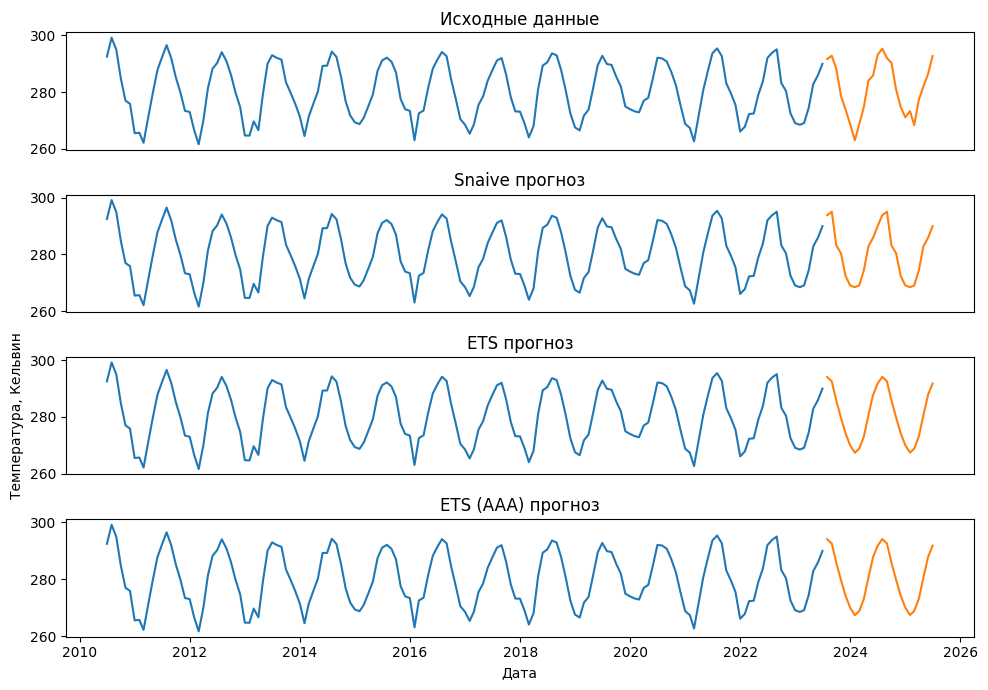

In [40]:
fig, ax = plt.subplots(figsize=(10, 7), nrows=4, ncols=1)

sns.lineplot(train, ax=ax[0])
sns.lineplot(test, ax=ax[0])

sns.lineplot(train, ax=ax[1])
sns.lineplot(snaive_forecast, ax=ax[1])

sns.lineplot(train, ax=ax[2])
sns.lineplot(ets_aaa_base.forecast(test.shape[0]), ax=ax[2])

sns.lineplot(train, ax=ax[3])
sns.lineplot(np.exp(ets_aaa_log.forecast(test.shape[0])), ax=ax[3])

ax[0].set_xticks([])
ax[0].set_xlabel('')
ax[0].set_ylabel('')
ax[0].set_title('Исходные данные')

ax[1].set_xticks([])
ax[1].set_xlabel('')
ax[2].set_ylabel('Температура, Кельвин')
ax[1].set_title('Snaive прогноз')

ax[2].set_xticks([])
ax[2].set_xlabel('')
ax[1].set_ylabel('')
ax[2].set_title('ETS прогноз')

ax[3].set_xlabel('Дата')
ax[3].set_ylabel('')
ax[3].set_title('ETS (AAA) прогноз')

plt.tight_layout()

plt.show()